# Neural Network Training Proess

First, start with Inline plotting, imports, and global variables used:

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Global vatiables list:**  
NAME: nickname for our model, must match the folder name in DL folder  
INP: Directory where we will read our input file  
DIR: Directory where we'll save model and export our parameters  
cat_vars: List of categorical variables in our model  
cont_vars: List of continous variables in our model  
QP: Quantization Parameter  
Layers: Number of neurons per hidden layer in our network  
Dropouts: Percentage of dropout rate per hidden layer  
BN_use: Use batch normalization if set to True  

In [2]:
# Imports and Global Variable Declarations
from fastai import *
from fastai.tabular import *

NAME='blowing'
INP='./DL'
DIR='./DL/{0}'.format(NAME)
cat_vars = ['Height', 'Width']
cont_vars = ['top_left', 'top_center', 'top_right', 'left', 'center', 'right', 
             'bottom_left', 'bottom_center', 'bottom_right']
QP=22
Layers=[22, 20]
Dropouts=[0.001, 0.01]
BN_use=True

### Helper Functions:

Helper functions to help us keep the code concise  
get_cv_idx(): return random list of indices from a list given a percentage value "borrowed from FastAIv0.7"  
read_proc(): Reads the input file, normalize and categorify, and return FastAI TabularDataBunch and Learner methods  
export_mapper(): export means and stds used for normalization "to be used for inference"  
save_model(): saves our model for later use  
export_parameters(): export each layer's weights and biases "to be used for inference"  

In [3]:
# Helper Functions
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

def read_proc():
    df = pd.read_csv('{0}/SSE_{1}.csv'.format(INP, QP), names=cont_vars+cat_vars+['y'])
    procs = [Categorify]
    normz = Normalize(cat_vars, cont_vars)
    normz(df)
    valid_idx = get_cv_idxs(len(df))
    data = TabularDataBunch.from_df(INP, df, 'y', valid_idx=valid_idx, procs=procs, cat_names=cat_vars, 
                                    cont_names=cont_vars)
    learn = tabular_learner(data, layers=Layers, metrics=accuracy, emb_drop=0.001, ps=Dropouts, use_bn=BN_use)
    return df, normz, valid_idx, data, learn

def export_mapper():
    mapper_df = pd.DataFrame(index=['mean', 'std'], columns=cont_vars)
    for column in cont_vars:
        mapper_df[column].loc['mean'] = normz.means[column]
        mapper_df[column].loc['std'] = normz.stds[column]
    mapper_df.to_csv('{0}/{1}/mapper_{1}.csv'.format(DIR, QP), index=False, header=None, line_terminator=';\n')    
    return
    
def save_model():
    acc = learn.recorder.metrics[-1][0].numpy() * 100
    learn.save(f'QP{QP}_{NAME}_acc{(acc.round(2))}')
    return

def export_parameters():
    e = l = bn = 0
    bn_list = ['weight', 'bias', 'running_mean', 'running_var']
    for idx, layer in enumerate(learn.layer_groups[0]):
        if isinstance(layer, nn.Embedding):
            pd.DataFrame(learn.layer_groups[0][idx].weight.data.numpy()).to_csv('{0}/{1}/emb{2}-weight.csv'.format(DIR, QP, e), 
                                                                       index=False, header=None, line_terminator= ',\n')
            e+=1
        if isinstance(layer, nn.Linear):
            pd.DataFrame(learn.layer_groups[0][idx].weight.data.numpy()).to_csv('{0}/{1}/lins{2}-weight.csv'.format(DIR, QP, l), 
                                                                     index=False, header=None, line_terminator= ',\n')
            pd.DataFrame(learn.layer_groups[0][idx].bias.data.numpy()).to_csv('{0}/{1}/lins{2}-bias.csv'.format(DIR, QP, l), 
                                                                   index=False, header=None, line_terminator=", ")
            l+=1
        if isinstance(layer, nn.BatchNorm1d):
            for i in bn_list:
                pd.DataFrame(getattr(learn.layer_groups[0][idx], i).data.numpy()).to_csv('{0}/{1}/bns{2}-{3}.csv'.format(DIR, QP, bn, i), 
                                                                         index=False, header=None, line_terminator=', ')
            bn += 1
    for i in bn_list:
        pd.DataFrame(getattr(learn.model.bn_cont, i).data.numpy()).to_csv('{0}/{1}/bn-{2}.csv'.format(DIR, QP, i), 
                                                                 index=False, header=None, line_terminator=', ')
    return

In [4]:
if 'df' in globals(): del df, valid_idx, data, learn
df, normz, valid_idx, data, learn = read_proc()

In [5]:
data.train_dl.batch_size=1024

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


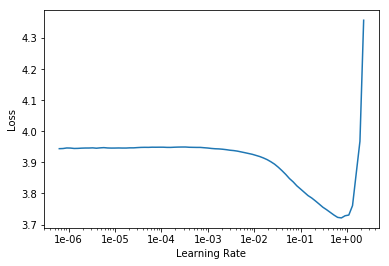

In [6]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(25, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,2.190524,2.450267,0.261376
2,2.221210,2.470271,0.257336
3,2.221597,2.581163,0.240704
4,2.241533,2.623444,0.254962
5,2.255086,2.581296,0.235131
6,2.238565,2.643877,0.248120
7,2.240588,2.448955,0.249305
8,2.290316,2.569303,0.238428
9,2.249609,2.526371,0.243447
10,2.258711,2.852398,0.211660


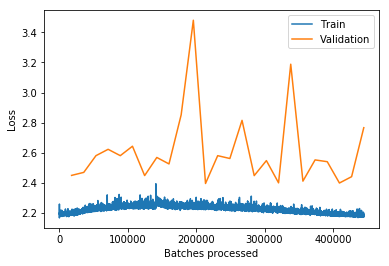

In [12]:
learn.recorder.plot_losses()

In [13]:
export_mapper()
save_model()
export_parameters()

In [15]:
for QP in [27, 32, 37]:
    if 'df' in globals(): del df, valid_idx, data, learn
    df, valid_idx, data, learn = read_proc()
    learn.fit_one_cycle(50, 1e-2)
    export_mapper()
    save_model()
    export_parameters()

FileNotFoundError: File b'./DL/SSE_27.csv' does not exist

# IMPLEMENTATION IN C++

In order to implement our model in HM-Tool, we need to know the values of weights and biases
To get a summary of all the layers used in our model, run this code:

In [ ]:
learn.model

This will vary depending on the model, but in general, you can see the following modules:  
**Linear:** used to multiply by weight and add bias for each layer (see torch.nn.linear)  
**BatchNorm1d:** used for batch normalization of each layer(see torch.nn.batchnorm1d)  
**outp:** Linear layer that is used for output  
There are also Embeddings, which are not used in this project  

We can reach any parameters we need from with m.model."module"  
Example: Find weights of first linear layer

In [ ]:
learn.model.layers[0].bias

The parameters that are of importance to us are:  
**weight:** The weights of each layer (found in lins, bns, bn, outp)  
**bias:** Biases of each layer (found in lins, bns, bn, outp)  
**running_mean:** The running mean computed during training - used for BatchNorm (found in bns, bn)  
**running_var:** The running variance computed during training - used for BatchNorm (found in bns, bn)  

To show all required parameters "including running_mean and running_var" run the following code:

In [ ]:
learn.model.state_dict()